<!--- Licensed to the Apache Software Foundation (ASF) under one -->
<!--- or more contributor license agreements.  See the NOTICE file -->
<!--- distributed with this work for additional information -->
<!--- regarding copyright ownership.  The ASF licenses this file -->
<!--- to you under the Apache License, Version 2.0 (the -->
<!--- "License"); you may not use this file except in compliance -->
<!--- with the License.  You may obtain a copy of the License at -->

<!---   http://www.apache.org/licenses/LICENSE-2.0 -->

<!--- Unless required by applicable law or agreed to in writing, -->
<!--- software distributed under the License is distributed on an -->
<!--- "AS IS" BASIS, WITHOUT WARRANTIES OR CONDITIONS OF ANY -->
<!--- KIND, either express or implied.  See the License for the -->
<!--- specific language governing permissions and limitations -->
<!--- under the License. -->

# Step 6: Train a Neural Network

Now that you have seen all the necessary components for creating a neural network, you are
now ready to put all the pieces together and train a model end to end.

## 1. Data preparation

The typical process for creating and training a model starts with loading and
preparing the datasets. For this Network you will use a [dataset of leaf
images](https://data.mendeley.com/datasets/hb74ynkjcn/1) that consists of healthy
and diseased examples of leafs from twelve different plant species. To get this
dataset you have to download and extract it with the following commands.

In [1]:
# Import all the necessary libraries to train
import time
import os
import zipfile

import mxnet as mx
from mxnet import np, npx, gluon, init, autograd
from mxnet.gluon import nn
from mxnet.gluon.data.vision import transforms

import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
import numpy as np

from prepare_dataset import process_dataset #utility code to rearrange the data

mx.np.random.seed(42)

In [2]:
# Download dataset
url = 'https://md-datasets-cache-zipfiles-prod.s3.eu-west-1.amazonaws.com/hb74ynkjcn-1.zip'
zip_file_path = mx.gluon.utils.download(url)

os.makedirs('plants', exist_ok=True)

with zipfile.ZipFile(zip_file_path, 'r') as zf:
    zf.extractall('plants')

os.remove(zip_file_path)

#### Data inspection

If you take a look at the dataset you find the following structure for the directories:

```
plants
|-- Alstonia Scholaris (P2)
|-- Arjun (P1)
|-- Bael (P4)
    |-- diseased
        |-- 0016_0001.JPG
        |-- .
        |-- .
        |-- .
        |-- 0016_0118.JPG
|-- .
|-- .
|-- .
|-- Mango (P0)
    |-- diseased
    |-- healthy
```


Each plant species has its own directory, for each of those directories you might
find subdirectories with examples of diseased leaves, healthy
leaves, or both. With this dataset you can formulate different classification
problems; for example, you can create a multi-class classifier that determines
the species of a plant based on the leaves; you can instead create a binary
classifier that tells you whether the plant is healthy or diseased. Additionally, you can create
a multi-class, multi-label classifier that tells you both: what species a
plant is and whether the plant is diseased or healthy. In this example you will stick to
the simplest classification question, which is whether a plant is healthy or not.

To do this, you need to manipulate the dataset in two ways. First, you need to
combine all images with labels consisting of healthy and diseased, regardless of the species, and then you
need to split the data into train, validation, and test sets. We prepared a
small utility script that does this to get the dataset ready for you.
Once you run this utility code on the data, the structure will be
already organized in folders containing the right images in each of the classes,
you can use the `ImageFolderDataset` class to import the images from the file to MXNet.

In [3]:
# Call the utility function to rearrange the images
process_dataset('plants')

The dataset is located in the `datasets` folder and the new structure
looks like this:

```
datasets
|-- test
    |-- diseased
    |-- healthy
|-- train
|-- validation
    |-- diseased
    |-- healthy
        |-- image1.JPG
        |-- image2.JPG
        |-- .
        |-- .
        |-- .
        |-- imagen.JPG
```


Now, you need to create three different Dataset objects from the `train`,
`validation`, and `test` folders, and the `ImageFolderDataset` class takes
care of inferring the classes from the directory names. If you don't remember
how the `ImageFolderDataset` works, take a look at [Step 5](5-datasets.md)
of this course for a deeper description.

In [4]:
# Use ImageFolderDataset to create a Dataset object from directory structure
train_dataset = gluon.data.vision.ImageFolderDataset('./datasets/train')
val_dataset = gluon.data.vision.ImageFolderDataset('./datasets/validation')
test_dataset = gluon.data.vision.ImageFolderDataset('./datasets/test')

The result from this operation is a different Dataset object for each folder.
These objects hold a collection of images and labels and as such they can be
indexed, to get the $i$-th element from the dataset. The $i$-th element is a
tuple with two objects, the first object of the tuple is the image in array
form and the second is the corresponding label for that image.

[03:09:23] /work/mxnet/src/storage/storage.cc:199: Using Pooled (Naive) StorageManager for CPU


Data type: uint8
Label: 0
Label description: diseased
Image shape: (4000, 6000, 3)


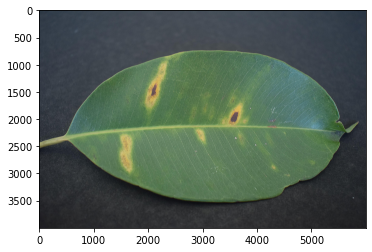

In [5]:
sample_idx = 888 # choose a random sample
sample = train_dataset[sample_idx]
data = sample[0]
label = sample[1]

plt.imshow(data.asnumpy())
print(f"Data type: {data.dtype}")
print(f"Label: {label}")
print(f"Label description: {train_dataset.synsets[label]}")
print(f"Image shape: {data.shape}")

As you can see from the plot, the image size is very large 4000 x 6000 pixels.
Usually, you downsize images before passing them to a neural network to reduce the training time.
It is also customary to make slight modifications to the images to improve generalization. That is why you add
transformations to the data in a process called Data Augmentation.

You can augment data in MXNet using `transforms`. For a complete list of all
the available transformations in MXNet check out
[available transforms](../../../api/gluon/data/vision/transforms/index.rst).
It is very common to use more than one transform per image, and it is also
common to process transforms sequentially. To this end, you can use the `transforms.Compose` class.
This class is very useful to create a transformation pipeline for your images.

You have to compose two different transformation pipelines, one for training
and the other one for validating and testing. This is because each pipeline
serves different pursposes. You need to downsize, convert to tensor and normalize
images across all the different datsets; however, you typically do not want to randomly flip
or add color jitter to the validation or test images since you could reduce performance.

In [6]:
# Import transforms as compose a series of transformations to the images
from mxnet.gluon.data.vision import transforms

jitter_param = 0.05

# mean and std for normalizing image value in range (0,1)
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

training_transformer = transforms.Compose([
    transforms.Resize(size=224, keep_ratio=True),
    transforms.CenterCrop(128),
    transforms.RandomFlipLeftRight(),
    transforms.RandomColorJitter(contrast=jitter_param),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

validation_transformer = transforms.Compose([
    transforms.Resize(size=224, keep_ratio=True),
    transforms.CenterCrop(128),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

With your augmentations ready, you can create the `DataLoaders` to use them. To
do this the `gluon.data.DataLoader` class comes in handy. You have to pass the dataset with
the applied transformations (notice the `.transform_first()` method on the datasets)
to `gluon.data.DataLoader`. Additionally, you need to decide the batch size,
which is how many images you will be passing to the network,
and whether you want to shuffle the dataset.

In [7]:
# Create data loaders
batch_size = 4
train_loader = gluon.data.DataLoader(train_dataset.transform_first(training_transformer),
                                     batch_size=batch_size,
                                     shuffle=True,
                                     try_nopython=True)
validation_loader = gluon.data.DataLoader(val_dataset.transform_first(validation_transformer),
                                          batch_size=batch_size,
                                          try_nopython=True)
test_loader = gluon.data.DataLoader(test_dataset.transform_first(validation_transformer),
                                    batch_size=batch_size,
                                    try_nopython=True)

Now, you can inspect the transformations that you made to the images. A prepared
utility function has been provided for this.

In [8]:
# Function to plot batch
def show_batch(batch, columns=4, fig_size=(9, 5), pad=1):
    labels = batch[1].asnumpy()
    batch = batch[0] / 2 + 0.5     # unnormalize
    batch = np.clip(batch.asnumpy(), 0, 1) # clip values
    size = batch.shape[0]
    rows = int(size / columns)
    fig, axes = plt.subplots(rows, columns, figsize=fig_size)
    for ax, img, label in zip(axes.flatten(), batch, labels):
        ax.imshow(np.transpose(img, (1, 2, 0)))
        ax.set(title=f"Label: {label}")
    fig.tight_layout(h_pad=pad, w_pad=pad)
    plt.show()

In [9]:
for batch in train_loader:
    a = batch
    break

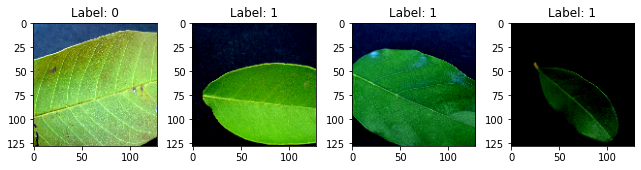

In [10]:
show_batch(a)

You can see that the original images changed to have different sizes and variations
in color and lighting. These changes followed the specified transformations you stated
in the pipeline. You are now ready to go to the next step: **Create the
architecture**.

## 2. Create Neural Network

Convolutional neural networks are a great tool to capture the spatial
relationship of pixel values within images, for this reason they have become the
gold standard for computer vision. In this example you will create a small convolutional neural
network using what you learned from [Step 2](2-create-nn.md) of this crash course series.
First, you can set up two functions that will generate the two types of blocks
you intend to use, the convolution block and the dense block. Then you can create an
entire network based on these two blocks using a custom class.

In [11]:
# The convolutional block has a convolution layer, a max pool layer and a batch normalization layer
def conv_block(filters, kernel_size=2, stride=2, batch_norm=True):
    conv_block = nn.HybridSequential()
    conv_block.add(nn.Conv2D(channels=filters, kernel_size=kernel_size, activation='relu'),
              nn.MaxPool2D(pool_size=4, strides=stride))
    if batch_norm:
        conv_block.add(nn.BatchNorm())
    return conv_block

# The dense block consists of a dense layer and a dropout layer
def dense_block(neurons, activation='relu', dropout=0.2):
    dense_block = nn.HybridSequential()
    dense_block.add(nn.Dense(neurons, activation=activation))
    if dropout:
        dense_block.add(nn.Dropout(dropout))
    return dense_block

In [12]:
# Create neural network blueprint using the blocks
class LeafNetwork(nn.HybridBlock):
    def __init__(self):
        super(LeafNetwork, self).__init__()
        self.conv1 = conv_block(32)
        self.conv2 = conv_block(64)
        self.conv3 = conv_block(128)
        self.flatten = nn.Flatten()
        self.dense1 = dense_block(100)
        self.dense2 = dense_block(10)
        self.dense3 = nn.Dense(2)

    def forward(self, batch):
        batch = self.conv1(batch)
        batch = self.conv2(batch)
        batch = self.conv3(batch)
        batch = self.flatten(batch)
        batch = self.dense1(batch)
        batch = self.dense2(batch)
        batch = self.dense3(batch)

        return batch

You have concluded the architecting part of the network, so now you can actually
build a model from that architecture for training. As you have seen
previously on [Step 4](4-components.md) of this
crash course series, to use the network you need to initialize the parameters and
hybridize the model.

In [13]:
# Create the model based on the blueprint provided and initialize the parameters
ctx = mx.gpu()

initializer = mx.initializer.Xavier()

model = LeafNetwork()
model.initialize(initializer, ctx=ctx)
model.summary(mx.np.random.uniform(size=(4, 3, 128, 128), ctx=ctx))
model.hybridize()

[03:09:29] /work/mxnet/src/storage/storage.cc:199: Using Pooled (Naive) StorageManager for GPU


--------------------------------------------------------------------------------
        Layer (type)                                Output Shape         Param #
               Input                            (4, 3, 128, 128)               0
        Activation-1                           (4, 32, 127, 127)               0
            Conv2D-2                           (4, 32, 127, 127)             416
         MaxPool2D-3                             (4, 32, 62, 62)               0
         BatchNorm-4                             (4, 32, 62, 62)             128
        Activation-5                             (4, 64, 61, 61)               0
            Conv2D-6                             (4, 64, 61, 61)            8256
         MaxPool2D-7                             (4, 64, 29, 29)               0
         BatchNorm-8                             (4, 64, 29, 29)             256
        Activation-9                            (4, 128, 28, 28)               0
           Conv2D-10        

[03:09:31] /work/mxnet/src/operator/nn/./cudnn/./cudnn_algoreg-inl.h:97: Running performance tests to find the best convolution algorithm, this can take a while... (set the environment variable MXNET_CUDNN_AUTOTUNE_DEFAULT to 0 to disable)


## 3. Choose Optimizer and Loss function

With the network created you can move on to choosing an optimizer and a loss
function. The network you created uses these components to make an informed decision on how
to tune the parameters to fit the final objective better. You can use the `gluon.Trainer` class to
help with optimizing these parameters. The `gluon.Trainer` class needs two things to work
properly: the parameters needing to be tuned and the optimizer with its
corresponding hyperparameters. The trainer uses the error reported by the loss
function to optimize these parameters.

For this particular dataset you will use Stochastic Gradient Descent as the
optimizer and Cross Entropy as the loss function.

In [14]:
# SGD optimizer
optimizer = 'sgd'

# Set parameters
optimizer_params = {'learning_rate': 0.001}

# Define the trainer for the model
trainer = gluon.Trainer(model.collect_params(), optimizer, optimizer_params)

# Define the loss function
loss_fn = gluon.loss.SoftmaxCrossEntropyLoss()

Finally, you have to set up the training loop, and you need to create a function to evaluate the performance of the network on the validation dataset.

In [15]:
# Function to return the accuracy for the validation and test set
def test(val_data):
    acc = gluon.metric.Accuracy()
    for batch in val_data:
        data = batch[0]
        labels = batch[1]
        outputs = model(data.as_in_ctx(ctx))
        acc.update([labels], [outputs])

    _, accuracy = acc.get()
    return accuracy

## 4. Training Loop

Now that you have everything set up, you can start training your network. This might
take some time to train depending on the hardware, number of layers, batch size and
images you use. For this particular case, you will only train for 2 epochs.

In [16]:
# Start the training loop
epochs = 2
accuracy = gluon.metric.Accuracy()
log_interval = 5

for epoch in range(epochs):
    tic = time.time()
    btic = time.time()
    accuracy.reset()

    for idx, batch in enumerate(train_loader):
        data = batch[0]
        label = batch[1]
        with mx.autograd.record():
            outputs = model(data.as_in_ctx(ctx))
            loss = loss_fn(outputs, label.as_in_ctx(ctx))
        mx.autograd.backward(loss)
        trainer.step(batch_size)
        accuracy.update([label], [outputs])
        if log_interval and (idx + 1) % log_interval == 0:
            _, acc = accuracy.get()

            print(f"""Epoch[{epoch + 1}] Batch[{idx + 1}] Speed: {batch_size / (time.time() - btic)} samples/sec \
                  batch loss = {loss.mean().item()} | accuracy = {acc}""")
            btic = time.time()

    _, acc = accuracy.get()

    acc_val = test(validation_loader)
    print(f"[Epoch {epoch + 1}] training: accuracy={acc}")
    print(f"[Epoch {epoch + 1}] time cost: {time.time() - tic}")
    print(f"[Epoch {epoch + 1}] validation: validation accuracy={acc_val}")

Epoch[1] Batch[5] Speed: 1.212617711377427 samples/sec                   batch loss = 1.7983338832855225 | accuracy = 0.55


Epoch[1] Batch[10] Speed: 1.2679148001244245 samples/sec                   batch loss = 1.1076219081878662 | accuracy = 0.6


Epoch[1] Batch[15] Speed: 1.256784315605589 samples/sec                   batch loss = 0.8703920841217041 | accuracy = 0.5666666666666667


Epoch[1] Batch[20] Speed: 1.2519179984493938 samples/sec                   batch loss = 2.004831552505493 | accuracy = 0.6


Epoch[1] Batch[25] Speed: 1.2513563395855594 samples/sec                   batch loss = 1.0358521938323975 | accuracy = 0.58


Epoch[1] Batch[30] Speed: 1.243408102377779 samples/sec                   batch loss = 0.645413875579834 | accuracy = 0.6166666666666667


Epoch[1] Batch[35] Speed: 1.25475423602179 samples/sec                   batch loss = 0.8280960321426392 | accuracy = 0.6142857142857143


Epoch[1] Batch[40] Speed: 1.2541484966857477 samples/sec                   batch loss = 0.4338177442550659 | accuracy = 0.63125


Epoch[1] Batch[45] Speed: 1.2612846383643461 samples/sec                   batch loss = 0.5317960977554321 | accuracy = 0.6333333333333333


Epoch[1] Batch[50] Speed: 1.2537396861304564 samples/sec                   batch loss = 0.6316758394241333 | accuracy = 0.625


Epoch[1] Batch[55] Speed: 1.2595374178096164 samples/sec                   batch loss = 0.8455548286437988 | accuracy = 0.6136363636363636


Epoch[1] Batch[60] Speed: 1.251620905418232 samples/sec                   batch loss = 0.9750739336013794 | accuracy = 0.6041666666666666


Epoch[1] Batch[65] Speed: 1.2524077952106338 samples/sec                   batch loss = 0.6849053502082825 | accuracy = 0.5961538461538461


Epoch[1] Batch[70] Speed: 1.253514682303084 samples/sec                   batch loss = 1.2347774505615234 | accuracy = 0.5821428571428572


Epoch[1] Batch[75] Speed: 1.2552363000356956 samples/sec                   batch loss = 0.6441552639007568 | accuracy = 0.5866666666666667


Epoch[1] Batch[80] Speed: 1.2564264746476517 samples/sec                   batch loss = 0.4343641698360443 | accuracy = 0.5875


Epoch[1] Batch[85] Speed: 1.2509935603405922 samples/sec                   batch loss = 0.4614397883415222 | accuracy = 0.5941176470588235


Epoch[1] Batch[90] Speed: 1.2506408734470154 samples/sec                   batch loss = 0.47733721137046814 | accuracy = 0.6


Epoch[1] Batch[95] Speed: 1.2572139562216116 samples/sec                   batch loss = 0.7489100694656372 | accuracy = 0.6


Epoch[1] Batch[100] Speed: 1.2557734370473919 samples/sec                   batch loss = 0.970787525177002 | accuracy = 0.6025


Epoch[1] Batch[105] Speed: 1.2553767174128543 samples/sec                   batch loss = 0.4073675870895386 | accuracy = 0.5976190476190476


Epoch[1] Batch[110] Speed: 1.2512074888021467 samples/sec                   batch loss = 0.9530728459358215 | accuracy = 0.5977272727272728


Epoch[1] Batch[115] Speed: 1.259191143910553 samples/sec                   batch loss = 0.3711903691291809 | accuracy = 0.6065217391304348


Epoch[1] Batch[120] Speed: 1.2573861020490924 samples/sec                   batch loss = 0.38250455260276794 | accuracy = 0.6125


Epoch[1] Batch[125] Speed: 1.254662840531467 samples/sec                   batch loss = 0.2966984510421753 | accuracy = 0.622


Epoch[1] Batch[130] Speed: 1.2602771131680024 samples/sec                   batch loss = 0.42607635259628296 | accuracy = 0.625


Epoch[1] Batch[135] Speed: 1.2520830903195006 samples/sec                   batch loss = 0.45942312479019165 | accuracy = 0.6203703703703703


Epoch[1] Batch[140] Speed: 1.254560575943346 samples/sec                   batch loss = 0.45255088806152344 | accuracy = 0.6178571428571429


Epoch[1] Batch[145] Speed: 1.2550130118869753 samples/sec                   batch loss = 0.42811843752861023 | accuracy = 0.6172413793103448


Epoch[1] Batch[150] Speed: 1.2567429868958684 samples/sec                   batch loss = 0.4837799668312073 | accuracy = 0.6166666666666667


Epoch[1] Batch[155] Speed: 1.2559861827577483 samples/sec                   batch loss = 0.36058294773101807 | accuracy = 0.6225806451612903


Epoch[1] Batch[160] Speed: 1.2602703916365456 samples/sec                   batch loss = 0.40617460012435913 | accuracy = 0.625


Epoch[1] Batch[165] Speed: 1.257962525841061 samples/sec                   batch loss = 0.36005112528800964 | accuracy = 0.6303030303030303


Epoch[1] Batch[170] Speed: 1.258076760816119 samples/sec                   batch loss = 0.578056812286377 | accuracy = 0.6338235294117647


Epoch[1] Batch[175] Speed: 1.254994329895365 samples/sec                   batch loss = 0.4424814283847809 | accuracy = 0.6328571428571429


Epoch[1] Batch[180] Speed: 1.2550706573165593 samples/sec                   batch loss = 0.8592489957809448 | accuracy = 0.6361111111111111


Epoch[1] Batch[185] Speed: 1.2565378898553903 samples/sec                   batch loss = 0.8203275799751282 | accuracy = 0.6351351351351351


Epoch[1] Batch[190] Speed: 1.2621267400566953 samples/sec                   batch loss = 0.39940959215164185 | accuracy = 0.6394736842105263


Epoch[1] Batch[195] Speed: 1.2628720473491508 samples/sec                   batch loss = 0.943694531917572 | accuracy = 0.6384615384615384


Epoch[1] Batch[200] Speed: 1.2576312579973659 samples/sec                   batch loss = 0.899574875831604 | accuracy = 0.63875


Epoch[1] Batch[205] Speed: 1.2607409773115386 samples/sec                   batch loss = 0.3760536015033722 | accuracy = 0.6426829268292683


Epoch[1] Batch[210] Speed: 1.2547404413934118 samples/sec                   batch loss = 0.7530460357666016 | accuracy = 0.6404761904761904


Epoch[1] Batch[215] Speed: 1.255307491007312 samples/sec                   batch loss = 0.9289247393608093 | accuracy = 0.6395348837209303


Epoch[1] Batch[220] Speed: 1.2483614211656928 samples/sec                   batch loss = 0.778475821018219 | accuracy = 0.6386363636363637


Epoch[1] Batch[225] Speed: 1.2592293258477565 samples/sec                   batch loss = 0.5825108885765076 | accuracy = 0.6388888888888888


Epoch[1] Batch[230] Speed: 1.2613213353098818 samples/sec                   batch loss = 0.5959787368774414 | accuracy = 0.6391304347826087


Epoch[1] Batch[235] Speed: 1.2572603094092998 samples/sec                   batch loss = 0.37133967876434326 | accuracy = 0.6446808510638298


Epoch[1] Batch[240] Speed: 1.2518028243059867 samples/sec                   batch loss = 0.6205125451087952 | accuracy = 0.6458333333333334


Epoch[1] Batch[245] Speed: 1.2552353608947857 samples/sec                   batch loss = 0.7595796585083008 | accuracy = 0.6428571428571429


Epoch[1] Batch[250] Speed: 1.260612618136298 samples/sec                   batch loss = 0.9873277544975281 | accuracy = 0.646


Epoch[1] Batch[255] Speed: 1.2588465716362416 samples/sec                   batch loss = 0.34399113059043884 | accuracy = 0.65


Epoch[1] Batch[260] Speed: 1.2541912488076479 samples/sec                   batch loss = 1.0350377559661865 | accuracy = 0.65


Epoch[1] Batch[265] Speed: 1.2509070021482935 samples/sec                   batch loss = 0.5225178599357605 | accuracy = 0.6481132075471698


Epoch[1] Batch[270] Speed: 1.2552116950077603 samples/sec                   batch loss = 0.5663838386535645 | accuracy = 0.6481481481481481


Epoch[1] Batch[275] Speed: 1.2576624630931381 samples/sec                   batch loss = 0.7707436084747314 | accuracy = 0.6518181818181819


Epoch[1] Batch[280] Speed: 1.2609635600728624 samples/sec                   batch loss = 0.454178124666214 | accuracy = 0.6517857142857143


Epoch[1] Batch[285] Speed: 1.2594469314766696 samples/sec                   batch loss = 1.451880693435669 | accuracy = 0.6491228070175439


Epoch[1] Batch[290] Speed: 1.2595631383461805 samples/sec                   batch loss = 0.549983561038971 | accuracy = 0.6482758620689655


Epoch[1] Batch[295] Speed: 1.254240661140862 samples/sec                   batch loss = 0.4962463974952698 | accuracy = 0.6483050847457628


Epoch[1] Batch[300] Speed: 1.260721366506077 samples/sec                   batch loss = 0.6954939961433411 | accuracy = 0.65


Epoch[1] Batch[305] Speed: 1.254034786478604 samples/sec                   batch loss = 0.606329619884491 | accuracy = 0.6516393442622951


Epoch[1] Batch[310] Speed: 1.2577107350530046 samples/sec                   batch loss = 0.3894628584384918 | accuracy = 0.6508064516129032


Epoch[1] Batch[315] Speed: 1.2618309512760673 samples/sec                   batch loss = 0.3177012503147125 | accuracy = 0.653968253968254


Epoch[1] Batch[320] Speed: 1.257293757429887 samples/sec                   batch loss = 0.2950744032859802 | accuracy = 0.6546875


Epoch[1] Batch[325] Speed: 1.2519335060760939 samples/sec                   batch loss = 0.7235516905784607 | accuracy = 0.6561538461538462


Epoch[1] Batch[330] Speed: 1.254499412799842 samples/sec                   batch loss = 0.5844335556030273 | accuracy = 0.6545454545454545


Epoch[1] Batch[335] Speed: 1.2504296549769358 samples/sec                   batch loss = 0.26778265833854675 | accuracy = 0.6544776119402985


Epoch[1] Batch[340] Speed: 1.2498195171216067 samples/sec                   batch loss = 0.5449085235595703 | accuracy = 0.6529411764705882


Epoch[1] Batch[345] Speed: 1.2554922683116394 samples/sec                   batch loss = 0.44579553604125977 | accuracy = 0.6543478260869565


Epoch[1] Batch[350] Speed: 1.257507112877443 samples/sec                   batch loss = 0.2523973882198334 | accuracy = 0.655


Epoch[1] Batch[355] Speed: 1.257008140365925 samples/sec                   batch loss = 0.25822964310646057 | accuracy = 0.6577464788732394


Epoch[1] Batch[360] Speed: 1.25904590359076 samples/sec                   batch loss = 0.7420771718025208 | accuracy = 0.65625


Epoch[1] Batch[365] Speed: 1.2622654744027941 samples/sec                   batch loss = 0.577239990234375 | accuracy = 0.6575342465753424


Epoch[1] Batch[370] Speed: 1.2597489815214167 samples/sec                   batch loss = 0.730523407459259 | accuracy = 0.6574324324324324


Epoch[1] Batch[375] Speed: 1.256588240202172 samples/sec                   batch loss = 0.5468121767044067 | accuracy = 0.658


Epoch[1] Batch[380] Speed: 1.2547859554334966 samples/sec                   batch loss = 0.41087308526039124 | accuracy = 0.6585526315789474


Epoch[1] Batch[385] Speed: 1.2630050506001023 samples/sec                   batch loss = 0.7456578612327576 | accuracy = 0.6571428571428571


Epoch[1] Batch[390] Speed: 1.2567990966924294 samples/sec                   batch loss = 0.3551291823387146 | accuracy = 0.6583333333333333


Epoch[1] Batch[395] Speed: 1.254951053649383 samples/sec                   batch loss = 0.48840343952178955 | accuracy = 0.6575949367088607


Epoch[1] Batch[400] Speed: 1.255941897882915 samples/sec                   batch loss = 0.6021885871887207 | accuracy = 0.6575


Epoch[1] Batch[405] Speed: 1.2602106583590131 samples/sec                   batch loss = 0.6106016635894775 | accuracy = 0.6580246913580247


Epoch[1] Batch[410] Speed: 1.2595113201035673 samples/sec                   batch loss = 0.39277440309524536 | accuracy = 0.6603658536585366


Epoch[1] Batch[415] Speed: 1.2607818114293883 samples/sec                   batch loss = 0.7433584332466125 | accuracy = 0.6608433734939759


Epoch[1] Batch[420] Speed: 1.2602991716552396 samples/sec                   batch loss = 0.48562732338905334 | accuracy = 0.6607142857142857


Epoch[1] Batch[425] Speed: 1.2662844942414497 samples/sec                   batch loss = 0.5124915242195129 | accuracy = 0.658235294117647


Epoch[1] Batch[430] Speed: 1.2617082529186734 samples/sec                   batch loss = 0.4898550510406494 | accuracy = 0.6604651162790698


Epoch[1] Batch[435] Speed: 1.25296019891766 samples/sec                   batch loss = 0.23890534043312073 | accuracy = 0.6637931034482759


Epoch[1] Batch[440] Speed: 1.265183572175731 samples/sec                   batch loss = 1.34744393825531 | accuracy = 0.6636363636363637


Epoch[1] Batch[445] Speed: 1.2694355749121538 samples/sec                   batch loss = 0.827882707118988 | accuracy = 0.6640449438202247


Epoch[1] Batch[450] Speed: 1.2593689364515919 samples/sec                   batch loss = 0.7809200882911682 | accuracy = 0.6661111111111111


Epoch[1] Batch[455] Speed: 1.2575368036714776 samples/sec                   batch loss = 0.42966535687446594 | accuracy = 0.6653846153846154


Epoch[1] Batch[460] Speed: 1.259476997593234 samples/sec                   batch loss = 1.676536202430725 | accuracy = 0.6625


Epoch[1] Batch[465] Speed: 1.2632049408996053 samples/sec                   batch loss = 0.3382362127304077 | accuracy = 0.6623655913978495


Epoch[1] Batch[470] Speed: 1.2677785574457172 samples/sec                   batch loss = 0.5645368099212646 | accuracy = 0.6622340425531915


Epoch[1] Batch[475] Speed: 1.2594910856700408 samples/sec                   batch loss = 0.39373913407325745 | accuracy = 0.6636842105263158


Epoch[1] Batch[480] Speed: 1.2664535883610057 samples/sec                   batch loss = 0.5555816292762756 | accuracy = 0.6651041666666667


Epoch[1] Batch[485] Speed: 1.2642222989153613 samples/sec                   batch loss = 1.0981091260910034 | accuracy = 0.6664948453608247


Epoch[1] Batch[490] Speed: 1.2583337945989472 samples/sec                   batch loss = 0.21217526495456696 | accuracy = 0.6683673469387755


Epoch[1] Batch[495] Speed: 1.263175362276394 samples/sec                   batch loss = 1.2361516952514648 | accuracy = 0.6681818181818182


Epoch[1] Batch[500] Speed: 1.2637619623469016 samples/sec                   batch loss = 0.686525821685791 | accuracy = 0.6695


Epoch[1] Batch[505] Speed: 1.2607818114293883 samples/sec                   batch loss = 0.4489537179470062 | accuracy = 0.6702970297029703


Epoch[1] Batch[510] Speed: 1.2624643706620513 samples/sec                   batch loss = 0.39840593934059143 | accuracy = 0.6700980392156862


Epoch[1] Batch[515] Speed: 1.2649562545049868 samples/sec                   batch loss = 0.4093049168586731 | accuracy = 0.6699029126213593


Epoch[1] Batch[520] Speed: 1.265174794652113 samples/sec                   batch loss = 0.3192523419857025 | accuracy = 0.6716346153846153


Epoch[1] Batch[525] Speed: 1.2689978298654117 samples/sec                   batch loss = 0.3159002959728241 | accuracy = 0.6728571428571428


Epoch[1] Batch[530] Speed: 1.2586570286653815 samples/sec                   batch loss = 0.10333270579576492 | accuracy = 0.6740566037735849


Epoch[1] Batch[535] Speed: 1.2529819084348413 samples/sec                   batch loss = 0.3408339023590088 | accuracy = 0.6752336448598131


Epoch[1] Batch[540] Speed: 1.2597841702201278 samples/sec                   batch loss = 0.8543081283569336 | accuracy = 0.6773148148148148


Epoch[1] Batch[545] Speed: 1.2613243697782242 samples/sec                   batch loss = 0.4505537748336792 | accuracy = 0.6788990825688074


Epoch[1] Batch[550] Speed: 1.2596334023718974 samples/sec                   batch loss = 0.8184735178947449 | accuracy = 0.6786363636363636


Epoch[1] Batch[555] Speed: 1.2576075016817108 samples/sec                   batch loss = 0.3961656391620636 | accuracy = 0.6788288288288288


Epoch[1] Batch[560] Speed: 1.26029377530161 samples/sec                   batch loss = 0.7494789958000183 | accuracy = 0.6799107142857143


Epoch[1] Batch[565] Speed: 1.269443835343216 samples/sec                   batch loss = 0.18387973308563232 | accuracy = 0.6800884955752212


Epoch[1] Batch[570] Speed: 1.266808364346218 samples/sec                   batch loss = 0.8482341170310974 | accuracy = 0.6785087719298246


Epoch[1] Batch[575] Speed: 1.2634224957096376 samples/sec                   batch loss = 0.2564375102519989 | accuracy = 0.6791304347826087


Epoch[1] Batch[580] Speed: 1.269043424220392 samples/sec                   batch loss = 0.613326370716095 | accuracy = 0.6801724137931034


Epoch[1] Batch[585] Speed: 1.2761283477876189 samples/sec                   batch loss = 0.3292067348957062 | accuracy = 0.6799145299145299


Epoch[1] Batch[590] Speed: 1.2660973867428322 samples/sec                   batch loss = 0.4406895935535431 | accuracy = 0.6809322033898305


Epoch[1] Batch[595] Speed: 1.268756186496364 samples/sec                   batch loss = 0.4545481503009796 | accuracy = 0.6810924369747899


Epoch[1] Batch[600] Speed: 1.265805846277302 samples/sec                   batch loss = 0.10890556871891022 | accuracy = 0.68125


Epoch[1] Batch[605] Speed: 1.2752699851738565 samples/sec                   batch loss = 0.5987344980239868 | accuracy = 0.6814049586776859


Epoch[1] Batch[610] Speed: 1.269938312236849 samples/sec                   batch loss = 0.807974636554718 | accuracy = 0.6811475409836065


Epoch[1] Batch[615] Speed: 1.2749061918365259 samples/sec                   batch loss = 0.6768692135810852 | accuracy = 0.6804878048780488


Epoch[1] Batch[620] Speed: 1.2590948487645952 samples/sec                   batch loss = 0.42954519391059875 | accuracy = 0.6794354838709677


Epoch[1] Batch[625] Speed: 1.261737478204531 samples/sec                   batch loss = 0.20189011096954346 | accuracy = 0.6804


Epoch[1] Batch[630] Speed: 1.2591519247769793 samples/sec                   batch loss = 0.2359594851732254 | accuracy = 0.6813492063492064


Epoch[1] Batch[635] Speed: 1.2540022614653363 samples/sec                   batch loss = 0.3230619728565216 | accuracy = 0.6818897637795276


Epoch[1] Batch[640] Speed: 1.257938757008755 samples/sec                   batch loss = 0.5188190340995789 | accuracy = 0.68203125


Epoch[1] Batch[645] Speed: 1.260130013218539 samples/sec                   batch loss = 0.5827345252037048 | accuracy = 0.6829457364341085


Epoch[1] Batch[650] Speed: 1.260939393390514 samples/sec                   batch loss = 0.4122265577316284 | accuracy = 0.6834615384615385


Epoch[1] Batch[655] Speed: 1.257656429358692 samples/sec                   batch loss = 0.2609221339225769 | accuracy = 0.683969465648855


Epoch[1] Batch[660] Speed: 1.2608043613334459 samples/sec                   batch loss = 0.9492863416671753 | accuracy = 0.6837121212121212


Epoch[1] Batch[665] Speed: 1.2577594821789089 samples/sec                   batch loss = 0.6778076887130737 | accuracy = 0.6823308270676691


Epoch[1] Batch[670] Speed: 1.257470826033096 samples/sec                   batch loss = 0.3490487039089203 | accuracy = 0.6824626865671641


Epoch[1] Batch[675] Speed: 1.2599567368103897 samples/sec                   batch loss = 0.6631693840026855 | accuracy = 0.6825925925925926


Epoch[1] Batch[680] Speed: 1.2577802267828695 samples/sec                   batch loss = 0.44718995690345764 | accuracy = 0.6838235294117647


Epoch[1] Batch[685] Speed: 1.2561307179716248 samples/sec                   batch loss = 0.5957589149475098 | accuracy = 0.6846715328467153


Epoch[1] Batch[690] Speed: 1.2630884414779442 samples/sec                   batch loss = 0.5739859342575073 | accuracy = 0.6844202898550724


Epoch[1] Batch[695] Speed: 1.2637521574164319 samples/sec                   batch loss = 0.35664719343185425 | accuracy = 0.6848920863309352


Epoch[1] Batch[700] Speed: 1.2629492409642553 samples/sec                   batch loss = 0.45425012707710266 | accuracy = 0.6860714285714286


Epoch[1] Batch[705] Speed: 1.2605026573746645 samples/sec                   batch loss = 0.8458313345909119 | accuracy = 0.6868794326241134


Epoch[1] Batch[710] Speed: 1.2597102005554157 samples/sec                   batch loss = 0.5492432713508606 | accuracy = 0.6873239436619718


Epoch[1] Batch[715] Speed: 1.2606078821353943 samples/sec                   batch loss = 0.8562469482421875 | accuracy = 0.6874125874125874


Epoch[1] Batch[720] Speed: 1.2641213275627192 samples/sec                   batch loss = 0.609966516494751 | accuracy = 0.6871527777777777


Epoch[1] Batch[725] Speed: 1.2600152158190443 samples/sec                   batch loss = 0.819025993347168 | accuracy = 0.6868965517241379


Epoch[1] Batch[730] Speed: 1.2606041880793928 samples/sec                   batch loss = 0.8533482551574707 | accuracy = 0.6856164383561644


Epoch[1] Batch[735] Speed: 1.254652613322419 samples/sec                   batch loss = 0.34901049733161926 | accuracy = 0.6863945578231293


Epoch[1] Batch[740] Speed: 1.2572511704005653 samples/sec                   batch loss = 0.46275755763053894 | accuracy = 0.6861486486486487


Epoch[1] Batch[745] Speed: 1.2543181160095866 samples/sec                   batch loss = 0.7564967274665833 | accuracy = 0.6848993288590604


Epoch[1] Batch[750] Speed: 1.2661271023706844 samples/sec                   batch loss = 2.2406017780303955 | accuracy = 0.685


Epoch[1] Batch[755] Speed: 1.2554218079158277 samples/sec                   batch loss = 0.411824494600296 | accuracy = 0.6857615894039735


Epoch[1] Batch[760] Speed: 1.257247967068126 samples/sec                   batch loss = 0.3362395763397217 | accuracy = 0.6868421052631579


Epoch[1] Batch[765] Speed: 1.2613948304454403 samples/sec                   batch loss = 0.6511926054954529 | accuracy = 0.6866013071895425


Epoch[1] Batch[770] Speed: 1.2573088331759188 samples/sec                   batch loss = 0.5766893029212952 | accuracy = 0.686038961038961


Epoch[1] Batch[775] Speed: 1.2666549543298136 samples/sec                   batch loss = 0.40467730164527893 | accuracy = 0.6861290322580645


Epoch[1] Batch[780] Speed: 1.2594403133418932 samples/sec                   batch loss = 0.38130882382392883 | accuracy = 0.6862179487179487


Epoch[1] Batch[785] Speed: 1.260114869742363 samples/sec                   batch loss = 0.2713336646556854 | accuracy = 0.6869426751592357


[Epoch 1] training: accuracy=0.686230964467005
[Epoch 1] time cost: 653.098961353302
[Epoch 1] validation: validation accuracy=0.7355555555555555


Epoch[2] Batch[5] Speed: 1.2662003941419684 samples/sec                   batch loss = 0.31793123483657837 | accuracy = 0.8


Epoch[2] Batch[10] Speed: 1.260736050868245 samples/sec                   batch loss = 0.510367751121521 | accuracy = 0.8


Epoch[2] Batch[15] Speed: 1.2636765788843167 samples/sec                   batch loss = 0.233367457985878 | accuracy = 0.8


Epoch[2] Batch[20] Speed: 1.2702446467111785 samples/sec                   batch loss = 0.7031340003013611 | accuracy = 0.8375


Epoch[2] Batch[25] Speed: 1.271105982068825 samples/sec                   batch loss = 0.642397940158844 | accuracy = 0.79


Epoch[2] Batch[30] Speed: 1.264051419114333 samples/sec                   batch loss = 0.5171067118644714 | accuracy = 0.7833333333333333


Epoch[2] Batch[35] Speed: 1.265221259666635 samples/sec                   batch loss = 0.7790161371231079 | accuracy = 0.7571428571428571


Epoch[2] Batch[40] Speed: 1.2647251095774423 samples/sec                   batch loss = 1.0714937448501587 | accuracy = 0.75625


Epoch[2] Batch[45] Speed: 1.2633682664682493 samples/sec                   batch loss = 0.8602079153060913 | accuracy = 0.7333333333333333


Epoch[2] Batch[50] Speed: 1.2661835754625732 samples/sec                   batch loss = 0.5886255502700806 | accuracy = 0.73


Epoch[2] Batch[55] Speed: 1.2678202319498524 samples/sec                   batch loss = 0.2751377522945404 | accuracy = 0.7454545454545455


Epoch[2] Batch[60] Speed: 1.2610762553831072 samples/sec                   batch loss = 0.3080609142780304 | accuracy = 0.7458333333333333


Epoch[2] Batch[65] Speed: 1.264508440260942 samples/sec                   batch loss = 0.3808571994304657 | accuracy = 0.7576923076923077


Epoch[2] Batch[70] Speed: 1.2617925165092485 samples/sec                   batch loss = 0.470364511013031 | accuracy = 0.7642857142857142


Epoch[2] Batch[75] Speed: 1.2641025639093681 samples/sec                   batch loss = 0.43353018164634705 | accuracy = 0.7666666666666667


Epoch[2] Batch[80] Speed: 1.2596433326443437 samples/sec                   batch loss = 0.36276859045028687 | accuracy = 0.7625


Epoch[2] Batch[85] Speed: 1.2601965541800926 samples/sec                   batch loss = 0.22184179723262787 | accuracy = 0.7676470588235295


Epoch[2] Batch[90] Speed: 1.2639267650618888 samples/sec                   batch loss = 0.47427958250045776 | accuracy = 0.7638888888888888


Epoch[2] Batch[95] Speed: 1.263476824758013 samples/sec                   batch loss = 0.4389926791191101 | accuracy = 0.7631578947368421


Epoch[2] Batch[100] Speed: 1.2631955250461033 samples/sec                   batch loss = 0.7021353840827942 | accuracy = 0.755


Epoch[2] Batch[105] Speed: 1.2606511705074692 samples/sec                   batch loss = 0.421372652053833 | accuracy = 0.7595238095238095


Epoch[2] Batch[110] Speed: 1.2662652840297526 samples/sec                   batch loss = 0.4270731210708618 | accuracy = 0.7568181818181818


Epoch[2] Batch[115] Speed: 1.2635662732994568 samples/sec                   batch loss = 0.13063910603523254 | accuracy = 0.7673913043478261


Epoch[2] Batch[120] Speed: 1.264113898232343 samples/sec                   batch loss = 0.5970281958580017 | accuracy = 0.7666666666666667


Epoch[2] Batch[125] Speed: 1.2662222782062156 samples/sec                   batch loss = 0.30749088525772095 | accuracy = 0.77


Epoch[2] Batch[130] Speed: 1.2627145522121266 samples/sec                   batch loss = 0.5449607968330383 | accuracy = 0.7730769230769231


Epoch[2] Batch[135] Speed: 1.25961420428912 samples/sec                   batch loss = 0.48101136088371277 | accuracy = 0.7703703703703704


Epoch[2] Batch[140] Speed: 1.2653553308393601 samples/sec                   batch loss = 0.2599812150001526 | accuracy = 0.7660714285714286


Epoch[2] Batch[145] Speed: 1.2614212907909688 samples/sec                   batch loss = 0.7202432751655579 | accuracy = 0.7655172413793103


Epoch[2] Batch[150] Speed: 1.259703863405019 samples/sec                   batch loss = 0.4469023644924164 | accuracy = 0.7616666666666667


Epoch[2] Batch[155] Speed: 1.2607265770470462 samples/sec                   batch loss = 0.3574226200580597 | accuracy = 0.7645161290322581


Epoch[2] Batch[160] Speed: 1.2641170413999216 samples/sec                   batch loss = 0.6582639813423157 | accuracy = 0.7671875


Epoch[2] Batch[165] Speed: 1.2592772455652086 samples/sec                   batch loss = 0.8351686000823975 | accuracy = 0.7621212121212121


Epoch[2] Batch[170] Speed: 1.2585777152168691 samples/sec                   batch loss = 0.13195078074932098 | accuracy = 0.7602941176470588


Epoch[2] Batch[175] Speed: 1.2572192320218165 samples/sec                   batch loss = 0.39966875314712524 | accuracy = 0.7628571428571429


Epoch[2] Batch[180] Speed: 1.2606934197940822 samples/sec                   batch loss = 0.6410162448883057 | accuracy = 0.7638888888888888


Epoch[2] Batch[185] Speed: 1.2605363728470873 samples/sec                   batch loss = 0.590532660484314 | accuracy = 0.7662162162162162


Epoch[2] Batch[190] Speed: 1.2588314589914127 samples/sec                   batch loss = 0.28734520077705383 | accuracy = 0.7671052631578947


Epoch[2] Batch[195] Speed: 1.2575020231678105 samples/sec                   batch loss = 0.3179319500923157 | accuracy = 0.767948717948718


Epoch[2] Batch[200] Speed: 1.2604145889476353 samples/sec                   batch loss = 0.5788627862930298 | accuracy = 0.77


Epoch[2] Batch[205] Speed: 1.2630387099027827 samples/sec                   batch loss = 0.14341482520103455 | accuracy = 0.7707317073170732


Epoch[2] Batch[210] Speed: 1.26668192272547 samples/sec                   batch loss = 0.5335994362831116 | accuracy = 0.7690476190476191


Epoch[2] Batch[215] Speed: 1.2593802805821404 samples/sec                   batch loss = 0.6447983980178833 | accuracy = 0.7662790697674419


Epoch[2] Batch[220] Speed: 1.2581025160751516 samples/sec                   batch loss = 0.31132325530052185 | accuracy = 0.7670454545454546


Epoch[2] Batch[225] Speed: 1.2582528232888897 samples/sec                   batch loss = 0.5236935615539551 | accuracy = 0.7644444444444445


Epoch[2] Batch[230] Speed: 1.2598022382996725 samples/sec                   batch loss = 0.49107250571250916 | accuracy = 0.7641304347826087


Epoch[2] Batch[235] Speed: 1.2595602069084604 samples/sec                   batch loss = 0.6669613718986511 | accuracy = 0.7606382978723404


Epoch[2] Batch[240] Speed: 1.261247753922357 samples/sec                   batch loss = 0.29180869460105896 | accuracy = 0.7625


Epoch[2] Batch[245] Speed: 1.2618954889904288 samples/sec                   batch loss = 0.6321182250976562 | accuracy = 0.7622448979591837


Epoch[2] Batch[250] Speed: 1.2570442121415555 samples/sec                   batch loss = 0.752268373966217 | accuracy = 0.761


Epoch[2] Batch[255] Speed: 1.2592689278773272 samples/sec                   batch loss = 0.8872765302658081 | accuracy = 0.7578431372549019


Epoch[2] Batch[260] Speed: 1.2585619481390935 samples/sec                   batch loss = 0.4818567633628845 | accuracy = 0.7567307692307692


Epoch[2] Batch[265] Speed: 1.2604668603359543 samples/sec                   batch loss = 0.5659764409065247 | accuracy = 0.7575471698113208


Epoch[2] Batch[270] Speed: 1.2575315252056234 samples/sec                   batch loss = 0.3864952325820923 | accuracy = 0.7592592592592593


Epoch[2] Batch[275] Speed: 1.2536948100602463 samples/sec                   batch loss = 0.427901029586792 | accuracy = 0.7581818181818182


Epoch[2] Batch[280] Speed: 1.2550870881726042 samples/sec                   batch loss = 0.19154882431030273 | accuracy = 0.7571428571428571


Epoch[2] Batch[285] Speed: 1.269770784991604 samples/sec                   batch loss = 0.6785550713539124 | accuracy = 0.7570175438596491


Epoch[2] Batch[290] Speed: 1.264666669229587 samples/sec                   batch loss = 1.2453498840332031 | accuracy = 0.756896551724138


Epoch[2] Batch[295] Speed: 1.2625087366857726 samples/sec                   batch loss = 0.195377379655838 | accuracy = 0.7567796610169492


Epoch[2] Batch[300] Speed: 1.262040533117813 samples/sec                   batch loss = 0.6547333598136902 | accuracy = 0.7558333333333334


Epoch[2] Batch[305] Speed: 1.2656211715773071 samples/sec                   batch loss = 0.26871028542518616 | accuracy = 0.7557377049180328


Epoch[2] Batch[310] Speed: 1.2696724806327682 samples/sec                   batch loss = 0.40289318561553955 | accuracy = 0.7540322580645161


Epoch[2] Batch[315] Speed: 1.2632699046027775 samples/sec                   batch loss = 0.18568120896816254 | accuracy = 0.753968253968254


Epoch[2] Batch[320] Speed: 1.2624695006209927 samples/sec                   batch loss = 0.5670290589332581 | accuracy = 0.75390625


Epoch[2] Batch[325] Speed: 1.2582801900483371 samples/sec                   batch loss = 0.6478832960128784 | accuracy = 0.7492307692307693


Epoch[2] Batch[330] Speed: 1.2654166981564843 samples/sec                   batch loss = 0.26683521270751953 | accuracy = 0.7484848484848485


Epoch[2] Batch[335] Speed: 1.262058096351633 samples/sec                   batch loss = 0.7155026793479919 | accuracy = 0.7507462686567165


Epoch[2] Batch[340] Speed: 1.2610747387439611 samples/sec                   batch loss = 0.674464762210846 | accuracy = 0.7492647058823529


Epoch[2] Batch[345] Speed: 1.260494039383226 samples/sec                   batch loss = 0.5812574028968811 | accuracy = 0.75


Epoch[2] Batch[350] Speed: 1.2565177508464553 samples/sec                   batch loss = 0.48390132188796997 | accuracy = 0.7492857142857143


Epoch[2] Batch[355] Speed: 1.2596696249788737 samples/sec                   batch loss = 0.5590082406997681 | accuracy = 0.7492957746478873


Epoch[2] Batch[360] Speed: 1.2637199830823238 samples/sec                   batch loss = 1.2875396013259888 | accuracy = 0.7472222222222222


Epoch[2] Batch[365] Speed: 1.2630491693734884 samples/sec                   batch loss = 0.42319539189338684 | accuracy = 0.7472602739726028


Epoch[2] Batch[370] Speed: 1.2679868615367407 samples/sec                   batch loss = 0.3486756682395935 | accuracy = 0.7479729729729729


Epoch[2] Batch[375] Speed: 1.2662903243214807 samples/sec                   batch loss = 0.5561190247535706 | accuracy = 0.7486666666666667


Epoch[2] Batch[380] Speed: 1.26979087055051 samples/sec                   batch loss = 0.6660807728767395 | accuracy = 0.7480263157894737


Epoch[2] Batch[385] Speed: 1.267131756517163 samples/sec                   batch loss = 1.3237922191619873 | accuracy = 0.7480519480519481


Epoch[2] Batch[390] Speed: 1.2677092976065107 samples/sec                   batch loss = 0.43438008427619934 | accuracy = 0.7487179487179487


Epoch[2] Batch[395] Speed: 1.262438721492688 samples/sec                   batch loss = 0.506735622882843 | accuracy = 0.7487341772151899


Epoch[2] Batch[400] Speed: 1.2638046108048668 samples/sec                   batch loss = 0.5553004145622253 | accuracy = 0.749375


Epoch[2] Batch[405] Speed: 1.2651040064680315 samples/sec                   batch loss = 1.0528911352157593 | accuracy = 0.7475308641975309


Epoch[2] Batch[410] Speed: 1.2572299721804825 samples/sec                   batch loss = 1.3044248819351196 | accuracy = 0.7463414634146341


Epoch[2] Batch[415] Speed: 1.2554943352693206 samples/sec                   batch loss = 0.08568158745765686 | accuracy = 0.7469879518072289


Epoch[2] Batch[420] Speed: 1.261776478990267 samples/sec                   batch loss = 0.5594308376312256 | accuracy = 0.7470238095238095


Epoch[2] Batch[425] Speed: 1.2603945148565296 samples/sec                   batch loss = 0.7801525592803955 | accuracy = 0.7458823529411764


Epoch[2] Batch[430] Speed: 1.2623601655215255 samples/sec                   batch loss = 0.306160032749176 | accuracy = 0.7441860465116279


Epoch[2] Batch[435] Speed: 1.2612012010612386 samples/sec                   batch loss = 0.7359366416931152 | accuracy = 0.7448275862068966


Epoch[2] Batch[440] Speed: 1.2688576117619477 samples/sec                   batch loss = 0.4510281980037689 | accuracy = 0.7448863636363636


Epoch[2] Batch[445] Speed: 1.2644878543424012 samples/sec                   batch loss = 0.5478686690330505 | accuracy = 0.7460674157303371


Epoch[2] Batch[450] Speed: 1.260524344929477 samples/sec                   batch loss = 0.4591284692287445 | accuracy = 0.7461111111111111


Epoch[2] Batch[455] Speed: 1.263268287562754 samples/sec                   batch loss = 0.4164634346961975 | accuracy = 0.7450549450549451


Epoch[2] Batch[460] Speed: 1.2621937769389175 samples/sec                   batch loss = 0.7923590540885925 | accuracy = 0.7451086956521739


Epoch[2] Batch[465] Speed: 1.2633260279687157 samples/sec                   batch loss = 0.19602829217910767 | accuracy = 0.7467741935483871


Epoch[2] Batch[470] Speed: 1.2623395545098017 samples/sec                   batch loss = 0.2858985364437103 | accuracy = 0.7462765957446809


Epoch[2] Batch[475] Speed: 1.263491858840172 samples/sec                   batch loss = 0.6752746105194092 | accuracy = 0.7457894736842106


Epoch[2] Batch[480] Speed: 1.2687894813661942 samples/sec                   batch loss = 0.5892022252082825 | accuracy = 0.7447916666666666


Epoch[2] Batch[485] Speed: 1.2695275983438012 samples/sec                   batch loss = 0.4737672209739685 | accuracy = 0.7448453608247423


Epoch[2] Batch[490] Speed: 1.2661532838545988 samples/sec                   batch loss = 0.8482557535171509 | accuracy = 0.7433673469387755


Epoch[2] Batch[495] Speed: 1.265684665330411 samples/sec                   batch loss = 0.5652793645858765 | accuracy = 0.7449494949494949


Epoch[2] Batch[500] Speed: 1.2702945626535178 samples/sec                   batch loss = 0.48728495836257935 | accuracy = 0.745


Epoch[2] Batch[505] Speed: 1.2715657102319666 samples/sec                   batch loss = 0.4194132089614868 | accuracy = 0.7455445544554455


Epoch[2] Batch[510] Speed: 1.2680224161286566 samples/sec                   batch loss = 0.28045645356178284 | accuracy = 0.7455882352941177


Epoch[2] Batch[515] Speed: 1.2655214085493594 samples/sec                   batch loss = 0.24831560254096985 | accuracy = 0.7470873786407767


Epoch[2] Batch[520] Speed: 1.252726120799115 samples/sec                   batch loss = 0.45228368043899536 | accuracy = 0.7471153846153846


Epoch[2] Batch[525] Speed: 1.258997907000147 samples/sec                   batch loss = 0.2775627672672272 | accuracy = 0.7471428571428571


Epoch[2] Batch[530] Speed: 1.2582408389104227 samples/sec                   batch loss = 0.7147178053855896 | accuracy = 0.745754716981132


Epoch[2] Batch[535] Speed: 1.266369370212586 samples/sec                   batch loss = 0.21454088389873505 | accuracy = 0.7467289719626168


Epoch[2] Batch[540] Speed: 1.2647475147318912 samples/sec                   batch loss = 0.35785171389579773 | accuracy = 0.7458333333333333


Epoch[2] Batch[545] Speed: 1.2660296479695077 samples/sec                   batch loss = 0.35813963413238525 | accuracy = 0.7463302752293578


Epoch[2] Batch[550] Speed: 1.2520102090838339 samples/sec                   batch loss = 0.28372064232826233 | accuracy = 0.7481818181818182


Epoch[2] Batch[555] Speed: 1.2498152342894764 samples/sec                   batch loss = 0.24084065854549408 | accuracy = 0.7486486486486487


Epoch[2] Batch[560] Speed: 1.261792611407024 samples/sec                   batch loss = 0.29546111822128296 | accuracy = 0.7495535714285714


Epoch[2] Batch[565] Speed: 1.2579694114245576 samples/sec                   batch loss = 0.55884850025177 | accuracy = 0.7504424778761062


Epoch[2] Batch[570] Speed: 1.2635125074981728 samples/sec                   batch loss = 0.44383853673934937 | accuracy = 0.7508771929824561


Epoch[2] Batch[575] Speed: 1.2639165767037643 samples/sec                   batch loss = 0.7008727788925171 | accuracy = 0.7513043478260869


Epoch[2] Batch[580] Speed: 1.2637596776893134 samples/sec                   batch loss = 0.2939423620700836 | accuracy = 0.75


Epoch[2] Batch[585] Speed: 1.2633594189811266 samples/sec                   batch loss = 0.4497431516647339 | accuracy = 0.7495726495726496


Epoch[2] Batch[590] Speed: 1.2652325186437836 samples/sec                   batch loss = 0.23687644302845 | accuracy = 0.75


Epoch[2] Batch[595] Speed: 1.261296775619042 samples/sec                   batch loss = 0.22770433127880096 | accuracy = 0.7504201680672269


Epoch[2] Batch[600] Speed: 1.262769485704101 samples/sec                   batch loss = 0.854323148727417 | accuracy = 0.75


Epoch[2] Batch[605] Speed: 1.2655204539552078 samples/sec                   batch loss = 0.2859126329421997 | accuracy = 0.7508264462809917


Epoch[2] Batch[610] Speed: 1.2657048128000135 samples/sec                   batch loss = 0.4503310024738312 | accuracy = 0.7504098360655738


Epoch[2] Batch[615] Speed: 1.258400523545483 samples/sec                   batch loss = 0.3432392477989197 | accuracy = 0.75


Epoch[2] Batch[620] Speed: 1.256733667129643 samples/sec                   batch loss = 0.23118892312049866 | accuracy = 0.7504032258064516


Epoch[2] Batch[625] Speed: 1.2615683129280777 samples/sec                   batch loss = 0.5218636989593506 | accuracy = 0.7508


Epoch[2] Batch[630] Speed: 1.262658293105449 samples/sec                   batch loss = 1.7227833271026611 | accuracy = 0.7496031746031746


Epoch[2] Batch[635] Speed: 1.2642582143134613 samples/sec                   batch loss = 0.6344040632247925 | accuracy = 0.7503937007874015


Epoch[2] Batch[640] Speed: 1.2684667770622546 samples/sec                   batch loss = 0.19235102832317352 | accuracy = 0.750390625


Epoch[2] Batch[645] Speed: 1.264206104310543 samples/sec                   batch loss = 0.3672252297401428 | accuracy = 0.7515503875968992


Epoch[2] Batch[650] Speed: 1.2616166005762137 samples/sec                   batch loss = 0.8824753761291504 | accuracy = 0.7519230769230769


Epoch[2] Batch[655] Speed: 1.2593625082016644 samples/sec                   batch loss = 0.9193929433822632 | accuracy = 0.7519083969465649


Epoch[2] Batch[660] Speed: 1.2560059286130367 samples/sec                   batch loss = 0.22906970977783203 | accuracy = 0.7522727272727273


Epoch[2] Batch[665] Speed: 1.2610249760455692 samples/sec                   batch loss = 0.30211353302001953 | accuracy = 0.7530075187969925


Epoch[2] Batch[670] Speed: 1.2598662848292936 samples/sec                   batch loss = 0.4091908931732178 | accuracy = 0.7533582089552239


Epoch[2] Batch[675] Speed: 1.2546311273437565 samples/sec                   batch loss = 0.5994887351989746 | accuracy = 0.7525925925925926


Epoch[2] Batch[680] Speed: 1.2548405766403257 samples/sec                   batch loss = 0.4143926501274109 | accuracy = 0.7536764705882353


Epoch[2] Batch[685] Speed: 1.2674083973620538 samples/sec                   batch loss = 0.5979856848716736 | accuracy = 0.7532846715328467


Epoch[2] Batch[690] Speed: 1.2630638129235128 samples/sec                   batch loss = 0.38880231976509094 | accuracy = 0.7539855072463768


Epoch[2] Batch[695] Speed: 1.2590282351288444 samples/sec                   batch loss = 0.3846690058708191 | accuracy = 0.7535971223021583


Epoch[2] Batch[700] Speed: 1.2633624632637872 samples/sec                   batch loss = 0.5881146788597107 | accuracy = 0.7528571428571429


Epoch[2] Batch[705] Speed: 1.2680607521543414 samples/sec                   batch loss = 0.512983500957489 | accuracy = 0.7524822695035461


Epoch[2] Batch[710] Speed: 1.2517584603591547 samples/sec                   batch loss = 0.5968655943870544 | accuracy = 0.7514084507042254


Epoch[2] Batch[715] Speed: 1.2644497340408896 samples/sec                   batch loss = 0.2047744244337082 | accuracy = 0.7513986013986014


Epoch[2] Batch[720] Speed: 1.2556472150504487 samples/sec                   batch loss = 0.36519744992256165 | accuracy = 0.7520833333333333


Epoch[2] Batch[725] Speed: 1.2582999137269026 samples/sec                   batch loss = 0.5415457487106323 | accuracy = 0.7520689655172413


Epoch[2] Batch[730] Speed: 1.2626149618059563 samples/sec                   batch loss = 0.7176247239112854 | accuracy = 0.7527397260273972


Epoch[2] Batch[735] Speed: 1.2628768003779323 samples/sec                   batch loss = 0.85910564661026 | accuracy = 0.753061224489796


Epoch[2] Batch[740] Speed: 1.2635629425416517 samples/sec                   batch loss = 0.4051155149936676 | accuracy = 0.7533783783783784


Epoch[2] Batch[745] Speed: 1.2635116510888036 samples/sec                   batch loss = 0.4434571862220764 | accuracy = 0.7533557046979866


Epoch[2] Batch[750] Speed: 1.2626737828661054 samples/sec                   batch loss = 0.18195801973342896 | accuracy = 0.7536666666666667


Epoch[2] Batch[755] Speed: 1.2663878188601871 samples/sec                   batch loss = 1.0160062313079834 | accuracy = 0.7529801324503311


Epoch[2] Batch[760] Speed: 1.2570541958186048 samples/sec                   batch loss = 0.7306109666824341 | accuracy = 0.7529605263157895


Epoch[2] Batch[765] Speed: 1.2621593080774824 samples/sec                   batch loss = 0.7354449033737183 | accuracy = 0.7522875816993464


Epoch[2] Batch[770] Speed: 1.2593372685020812 samples/sec                   batch loss = 0.27338898181915283 | accuracy = 0.7532467532467533


Epoch[2] Batch[775] Speed: 1.2554253777190119 samples/sec                   batch loss = 0.3654622435569763 | accuracy = 0.7538709677419355


Epoch[2] Batch[780] Speed: 1.2604286033147862 samples/sec                   batch loss = 0.3314770758152008 | accuracy = 0.7541666666666667


Epoch[2] Batch[785] Speed: 1.2653668785112593 samples/sec                   batch loss = 0.5090815424919128 | accuracy = 0.7550955414012739


[Epoch 2] training: accuracy=0.7557106598984772
[Epoch 2] time cost: 642.7757732868195
[Epoch 2] validation: validation accuracy=0.7777777777777778


## 5. Test on the test set

Now that your network is trained and has reached a decent accuracy, you can
evaluate the performance on the test set. For that, you can use the `test_loader` data
loader and the test function you created previously.

In [17]:
test(test_loader)

0.7866666666666666

You have a trained network that can confidently discriminate between plants that
are healthy and the ones that are diseased. You can now start your garden and
set cameras to automatically detect plants in distress! Or change your classification
problem to create a model that classify the species of the plants! Either way you
might be able to impress your botanist friends.

## 6. Save the parameters

If you want to preserve the trained weights of the network you can save the
parameters in a file. Later, when you want to use the network to make predictions
you can load the parameters back!

In [18]:
# Save parameters in the
model.save_parameters('leaf_models.params')

This is the end of this tutorial, to see how you can speed up the training by
using GPU hardware continue to the [next tutorial](./7-use-gpus.ipynb)